# Alessio Code

In [56]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml

from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import SubprocVecEnv

# Plotting and monitoring
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common import results_plotter
from stable_baselines3.common.results_plotter import ts2xy, load_results
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback

import os
LOG_DIR = os.path.join( os.getcwd(), 'log')
os.makedirs(LOG_DIR, exist_ok=True)

In [44]:
X, Y, Z = qml.PauliX, qml.PauliY, qml.PauliZ
Id = qml.Identity(wires=[0]).matrix()

def layer(params):
    """ one qubit """
    U = qml.RX(params[1],wires=0).matrix() @ qml.RZ(params[0],wires=0).matrix()
    return U

def profit(state, target_state):
    """ state fidelity """
    return np.abs(np.trace(target_state.conj().T, state))

def profit2(gate, target_gate):
    """ gate fidelity """
    return np.abs(np.trace(target_gate.conj().T @ gate)) / 2**num_wires

proj_0 = 1/2*(Z(wires= [0]) + qml.Identity(wires=[0]))
proj_1 = 1/2*(-Z(wires= [0]) + qml.Identity(wires=[0]))
ops =  [proj_0 @ (Z(1)/2),proj_1 @ (Z(1)/2),proj_1 @ (X(1)/2)]
couplings = [-2*np.pi*0.158,-2*np.pi*(0.158-0.152),-2*np.pi*0.110]
H = qml.dot(couplings,ops)

def Ufree(t):
    evo = qml.exp(H, -1j * t)
    return evo.matrix()

def Upulse(t, phi):
    rabi_f = 0.5*2*np.pi
    ops = [X(0) @ qml.Identity(1),Y(0) @ qml.Identity(1)]
    couplings=[rabi_f*np.cos(phi),rabi_f*np.sin(phi)]
    Hmw = qml.dot(couplings, ops)
    
    evo = qml.exp(H+Hmw, -1j * abs(t))
    return evo.matrix()
    
def suter_layer(params):
    """ two qubit indirect control. """
    U = Upulse([params[1],params[2]]) @ Ufree(params[0])
    return U

def F12_V6():
    """ process fidelity """
    pass

# Solution:
# [0, np.pi/2], [np.pi/2, 0] = [2, 4], [4, 2]
# [0, -np.pi/2], [-np.pi/2, 0] = [2, 0], [0, 2]
# target_state = qml.Hadamard(wires=0).matrix() @ np.array([1,0])
# state = layer([np.pi/2, 0]) @ layer([0, np.pi/2]) @ np.array([1,0])
# profit(target_state, state)

## Example 1: Single qubit superposition state

In [45]:
psi0 = np.array([1,0])

class Parametric_env(gym.Env):
    MAX_STEPS = 4
    INFIDELITY_THRESHOLD = 1e-06

    def __init__(self, env_conf):
        self.target = env_conf["Target"]
        self.alpha = env_conf["Lagrange_time"]

        self.U = Id
        self.psi=psi0
        self.psi0=psi0
        
        self.action_space = gym.spaces.MultiDiscrete([5,5])
        self.observation_space = gym.spaces.Box(low=-1, high=1, shape=(4,), dtype=np.float64)
        
    def _get_obs(self):
        ob = np.concatenate([np.real(self.psi),np.imag(self.psi)])
        return ob
    
    def reset(self,seed=None, options=None):
        super().reset(seed=seed)
        self.U = Id
        self.psi=psi0
        self.fidelity = profit(self.psi,self.target)
        self.count = 0
        self.reward = 0
        self.done = False
        self.duration = 0
        observation = self._get_obs()
        self.info = {}

        return observation,{}
    
    def _get_params(self,para):
        az = 0
    
        if para==0:
            az = -np.pi/2
        elif para == 1:
            az = -np.pi/4
        elif para == 2:
            az = 0
        elif para == 3:
            az = np.pi/4
        elif para == 4:
            az = np.pi/2
        return az

    def step(self, action):
        if self.done:
            print("EPISODE DONE!!!")
        elif (self.count == self.MAX_STEPS):
            self.done = True
        else:
            assert self.action_space.contains(action)
            self.count += 1
            
        self.params = [self._get_params(action[0]),self._get_params(action[1])] 
        op = layer(self.params)

        self.U = op @ self.U  
        self.psi = self.U @ self.psi0

        self.fidelity = profit(self.psi,self.target)
        self.info = {"Fidelity": self.fidelity}

        if self.done:
            self.reward = self.fidelity
        else:
            self.reward = 0

        observation = self._get_obs()
        return [observation, self.reward, self.done,self.done, self.info]

### Training and testing

In [46]:
target_state = np.array([[1,1],[1,-1]])/np.sqrt(2) @ np.array([1,0])
env = Parametric_env(env_conf={"Target": target_state,"Lagrange_time":1})
check_env(env, warn=True)

In [48]:
vec_env_test = make_vec_env(lambda:Parametric_env(env_conf={"Target": target_state, "Lagrange_time":0})
, n_envs=1)

vec_env = make_vec_env(lambda:Parametric_env(env_conf={"Target": target_state, "Lagrange_time":0})
, n_envs=2,seed=0, vec_env_cls=SubprocVecEnv)

model = PPO("MlpPolicy", vec_env, verbose=1)

Using cpu device


In [49]:
mean_reward, std_reward = evaluate_policy(model, vec_env_test, n_eval_episodes=10)
print(f"Mean reward: {mean_reward} +/- {std_reward:.2f}")

Mean reward: 0.5 +/- 0.00


In [8]:
model.learn(50_000)
# model.save("Simple_example")
# model_loaded = PPO.load("Simple_example")

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5        |
|    ep_rew_mean     | 0.519    |
| time/              |          |
|    fps             | 641      |
|    iterations      | 1        |
|    time_elapsed    | 6        |
|    total_timesteps | 4096     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 5           |
|    ep_rew_mean          | 0.52        |
| time/                   |             |
|    fps                  | 456         |
|    iterations           | 2           |
|    time_elapsed         | 17          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.012180576 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.21       |
|    explained_variance   | -1.22       |
|    learning_rate        | 0.

In [9]:
mean_reward, std_reward = evaluate_policy(model, vec_env_test, n_eval_episodes=10)
print(f"Mean reward: {mean_reward} +/- {std_reward:.2f}")

Mean reward: 1.0 +/- 0.00


In [10]:
obs = vec_env.reset()
n_steps = 8
for step in range(n_steps):
    action, _ = model.predict(obs, deterministic= False)
    print(f"Step {step + 1}")
    print("Action: ", action)
    obs, reward, done, info = vec_env.step(action)
    print("reward=", reward)
    print("Fidelity:", info)
    if done.all():
        if info[0]["Fidelity"] > 0.99:
            print("Goal reached", "Fidelity=", info)
        else:
            print(" Max number of layers", "Fidelity=", info[0]["Fidelity"],"Fidelity=",info[1]["Fidelity"])
        break

Step 1
Action:  [[1 1]
 [3 2]]
reward= [0 0]
Fidelity: ({'Fidelity': np.float64(0.5000000000000001), 'TimeLimit.truncated': False}, {'Fidelity': np.float64(0.4999999999999999), 'TimeLimit.truncated': False})
Step 2
Action:  [[0 4]
 [1 3]]
reward= [0 0]
Fidelity: ({'Fidelity': np.float64(0.8535533905932742), 'TimeLimit.truncated': False}, {'Fidelity': np.float64(0.4999999999999999), 'TimeLimit.truncated': False})
Step 3
Action:  [[3 0]
 [3 0]]
reward= [0 0]
Fidelity: ({'Fidelity': np.float64(1.0000000000000004), 'TimeLimit.truncated': False}, {'Fidelity': np.float64(0.7499999999999999), 'TimeLimit.truncated': False})
Step 4
Action:  [[2 4]
 [1 3]]
reward= [0 0]
Fidelity: ({'Fidelity': np.float64(1.0000000000000009), 'TimeLimit.truncated': False}, {'Fidelity': np.float64(0.9267766952966368), 'TimeLimit.truncated': False})
Step 5
Action:  [[2 4]
 [2 2]]
reward= [1.        0.9267767]
Fidelity: ({'Fidelity': np.float64(1.0000000000000009), 'episode': {'r': 1.0, 'l': 5, 't': 136.604352}, 'Ti

### Monitoring

In [50]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    def __init__(self, check_freq, log_dir, verbose=1):
        
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [53]:
vec_env = Parametric_env(env_conf={"Target": target_state,"Lagrange_time":0})

vec_env = Monitor(vec_env, LOG_DIR)
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=LOG_DIR)

model_monitor = PPO("MlpPolicy", vec_env, verbose=1)
model_monitor.learn(total_timesteps=50_000, callback=callback)

Using cpu device
Wrapping the env in a DummyVecEnv.
Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: 0.50
Saving new best model to C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\development\log\best_model.zip
Num timesteps: 2000
Best mean reward: 0.50 - Last mean reward per episode: 0.54
Saving new best model to C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\development\log\best_model.zip
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5        |
|    ep_rew_mean     | 0.536    |
| time/              |          |
|    fps             | 687      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
Num timesteps: 3000
Best mean reward: 0.54 - Last mean reward per episode: 0.49
Num timesteps: 4000
Best mean reward: 0.54 - Last mean reward per episode: 0.47
----------------------------------------

In [57]:
def moving_average(values, window):
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "valid")

def plot_results(log_dir, title="Learning Curve"):

    x, y = ts2xy(load_results(log_dir), "timesteps")
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y) :]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.title(title + " Smoothed")
    plt.show()

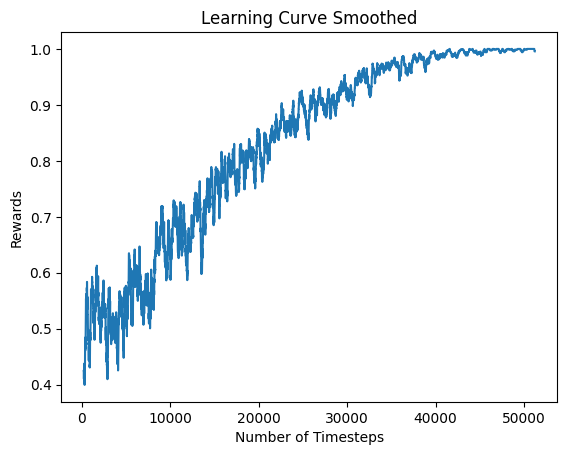

In [58]:
plot_results(LOG_DIR)

## Example 2: Hadamard gate on C13 spin (using Suter indirect control)

In [ ]:
# two options for the observation: hot encoding of count, unitary + count/Max_STEPS

In [ ]:
class Parametric_env(gym.Env):
    MAX_STEPS = 3
    INFIDELITY_THRESHOLD = 0.001

    def __init__(self, env_conf):
        self.target = env_conf["Target"]
        self.alpha = env_conf["Lagrange_time"]

        self.U = Id
        self.action_space = spaces.Box(low=-1, high= 1, shape=(3,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-1, high=1, shape=(5,), dtype=np.float64)
        # self.observation_space = spaces.Box(low=-1, high=1, shape=(33,), dtype=np.float64)

    def _hot_encode(self,observation):
        observation_encoded=np.zeros(5, np.float32)
        observation_encoded[observation]=1
        return observation_encoded

    def _get_obs(self):
        obs = self.count
        ob = self._hot_encode(obs)
        # v = self.count/self.MAX_STEPS
        # ob = np.concatenate([np.real(self.U.reshape(16,)),np.imag(self.U.reshape(16,)),[v]])
        return ob
    
    def reset(self,seed=None, options=None):
        super().reset(seed=seed)
        self.U = Id
        
        self.fidelity = profit(self.U,self.target)
        self.count = 0
        self.reward = 0
        self.done = False
        self.duration = 0
        observation = self._get_obs()
        self.info = {}
        return observation,{}
    
    def _get_angle(self,para):
        az = np.pi*para
        return az
    
    def _get_times(self,para):
        az = 1*np.abs(para)
        return az
        
    def _get_times2(self,para):
        az = 1.6*np.abs(para)   
        return az

    def step(self, action):
        if self.done:
            print("EPISODE DONE!!!")
        elif (self.count == self.MAX_STEPS):
            self.count+= 1
            self.done = True
        else:
            assert self.action_space.contains(action)
            self.count += 1

        self.params = [self._get_times(action[0]),self._get_times2(action[1]),self._get_angle(action[2])] 
        op = suter_layer(self.params)

        self.U = op @ self.U  
        self.fidelity = profit(self.U,self.target)
        self.info = {"Fidelity": self.fidelity}#,"Pre":Upre,"Next":self.U}

        if self.done:
            self.reward = F12_V6(self.target,self.U,1,1,1)
        else:
            self.reward = 0

        observation = self._get_obs()
        return [observation, self.reward, self.done,self.done, self.info]

### Training and testing

In [ ]:
target_gate = np.kron(np.eye(2), np.array([[1,1],[1,-1]])/np.sqrt(2) )
env = Parametric_env(env_conf={"Target": target_gate,"Lagrange_time":1})
check_env(env, warn=True)

In [ ]:
vec_env_test = make_vec_env(lambda:Parametric_env(env_conf={"Target": target_state,"Lagrange_time":0})
, n_envs=1)

vec_env = make_vec_env(lambda:Parametric_env(env_conf={"Target": target_state,"Lagrange_time":0})
, n_envs=12,seed=0, vec_env_cls=SubprocVecEnv)

model = PPO("MlpPolicy", vec_env, learning_rate=0.00005,gamma=0.9996,n_steps=209,batch_size=209,clip_range=0.2, n_epochs=10,ent_coef=0.001, verbose=1)

In [ ]:
mean_reward, std_reward = evaluate_policy(model, vec_env_test, n_eval_episodes=10)
print(f"Mean reward: {mean_reward} +/- {std_reward:.2f}")

In [ ]:
model.learn(5_000)
# model_vec.save("Hadamard_QB2_Single_shot_on_qubit2_5Mshots_PPO")
# model_loaded = PPO.load("Hadamard_QB2_Single_shot_on_qubit2_5Mshots_PPO")

In [ ]:
mean_reward, std_reward = evaluate_policy(model, vec_env_test, n_eval_episodes=10)
print(f"Mean reward: {mean_reward} +/- {std_reward:.2f}")

In [ ]:
obs = vec_env.reset()
n_steps = 8
actions_list = [] # can be used to calculate fidelities 
for step in range(n_steps):
    action, _ = model_vec.predict(obs, deterministic= False)
    print(f"Step {step + 1}")
    print("Action: ", [action[0][i] for i in range(3)])
    actions_list.append(action)
    obs, reward, done, info = vec_env.step(action)
    print("reward=", reward,info, "done=", done)
    if done.all():
        if info[0]["Fidelity"] > 0.99:
            print("Goal reached", "Fidelity=", info[0])
        else:
            print(" Max number of layers", "Fidelity=", info)
        break